In [1]:
import os
import pickle
import numpy as np
import time
from IPython.display import clear_output

import matplotlib
import matplotlib.pyplot as plt
#import config InlineBackend.figure_format = 'svg'
import tensorflow as tf

# silencing tensorflow warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)
from datetime import datetime

tf.__version__ # printint out tensorflow version used
import stable_baselines3
import sb3_contrib
from stable_baselines3.common.callbacks import BaseCallback
# from stable_baselines3.results_plotter import load_results, ts2xy
from stable_baselines3.common.results_plotter import load_results, ts2xy
import optuna
# from stable_baselines3.bench import Monitor
from stable_baselines3.common.monitor import Monitor
#from stable_baselines3.common.policies import MlpPolicy
from stable_baselines3.common import results_plotter

from sb3_contrib import MaskablePPO
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
#stable_baselines.__version__ # printing out stable_baselines version used
import gym
import pickle
import cProfile 
import pandas as pd
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)
import ast

In [2]:
# def make_env(env_args, log_dir):
#     def maker():
#         env = gym.make('RWAFOCS-v2111', **env_args)
#         env = Monitor(env, log_dir + 'evaluation', info_keywords=('episode_services_accepted',
# 'episode_services_processed', 'services_accepted', 'services_processed', 'episode_cum_services_accepted',
# 'episode_cum_services_processed', 'throughput'))
#         return env
#     return maker

In [5]:
with open('/Users/joshnevin/RL_FOCSLab/topologies/nsfnet_chen_5-paths_rounded.h5', 'rb') as f:
    topology = pickle.load(f)
# node probabilities from https://github.com/xiaoliangchenUCD/DeepRMSA/blob/6708e9a023df1ec05bfdc77804b6829e33cacfe4/Deep_RMSA_A3C.py#L77
# node_request_probabilities = np.array([0.01801802, 0.04004004, 0.05305305, 0.01901902, 0.04504505,
#        0.02402402, 0.06706707, 0.08908909, 0.13813814, 0.12212212,
#        0.07607608, 0.12012012, 0.01901902, 0.16916917])
node_request_probabilities = pickle.load(open('/Users/joshnevin/RL_FOCSLab/node_req_probs/14_node_uniform.pkl','rb'))
load = 1e10
env_args = dict(topology=topology, seed=10, load = load,
                allow_rejection=False, # the agent cannot proactively reject a request
                mean_service_holding_time=1e8, # value is not set as in the paper to achieve comparable reward values
                episode_length=2000, node_request_probabilities=node_request_probabilities, exp_request_res=25e9,
                term_on_first_block=False)

In [43]:
# current_directory = os.getcwd()
# exp_id = "2022-03-02v45nsf100GR2"
exp_id = "2022-03-02v45nsfUp5100GR2"
env_id = "RWAFOCS-v45"
model_dir = "/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/"+exp_id+"/_core_0/"
masks = True
# env = DummyVecEnv([make_env(env_args, log_dir)])
# os.makedirs(model_dir, exist_ok=True)
env = gym.make(env_id, **env_args)
env = Monitor(env, model_dir + 'training', info_keywords=('episode_services_accepted',
'episode_services_processed', 'services_accepted', 'services_processed', 'episode_cum_services_accepted',
'episode_cum_services_processed', 'throughput'))
# from sb3_contrib.common.maskable.evaluation import evaluate_policy
# from stable_baselines3.common.evaluation import evaluate_policy
if masks:
    from sb3_contrib.common.maskable.evaluation import evaluate_policy
    model = MaskablePPO.load(model_dir+'best_model')
else:
    from stable_baselines3.common.evaluation import evaluate_policy
    model = PPO.load(model_dir+'best_model')

In [44]:
# # current_directory = os.getcwd()
# exp_id = "2022-02-17_v43test"
# env_id = "RWAFOCS-v45"
# model_dir = "/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/"+exp_id+"/"
# # env = DummyVecEnv([make_env(env_args, log_dir)])
# # os.makedirs(model_dir, exist_ok=True)
# env = gym.make(env_id, **env_args)
# env = Monitor(env, model_dir + 'training', info_keywords=('episode_services_accepted',
# 'episode_services_processed', 'services_accepted', 'services_processed', 'episode_cum_services_accepted',
# 'episode_cum_services_processed', 'throughput','service_distribution'))
# #model = MaskablePPO.load(model_dir+'best_model')
# model = MaskablePPO.load(model_dir+'best_model')
# # model = PPO.load(model_dir+'best_model')

In [31]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1, deterministic = False)
print(mean_reward)
print(std_reward)

KeyboardInterrupt: 

In [ ]:
2293- (2500 - 2293)

In [ ]:
env

In [45]:
model_corex_dir = "/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/"+exp_id+"/_core_4/"
# model_corex_dir = "/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/"+exp_id+"/"
df = pd.read_csv(model_corex_dir+"/training.monitor.csv", skiprows=1)
rewards = df['r'].to_numpy()
sim_time = df['t'].to_numpy()
episodes = df.index.values
# services_accepted_ep = df['episode_services_accepted']
# services_processed_ep = df['episode_services_processed']
services_accepted = df['services_accepted']
# services_processed = df['services_processed']
throughput = df['throughput']/1e12
# service_dist = df['service_distribution']
# service_dist = service_dist[0]
# service_dist = ast.literal_eval(service_dist)
# service_dist = np.array(service_dist).reshape(22,100)
# np.array(service_dist).reshape(22,100)
# cum_services_accepted = df['episode_cum_services_accepted']
# cum_services_accepted = cum_services_accepted[0]
# cum_services_accepted = ast.literal_eval(cum_services_accepted)

In [46]:
episodes[-1]

99

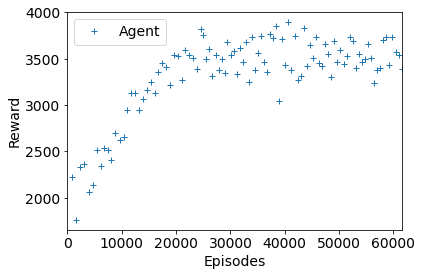

In [47]:
ca_mu_result_reward = np.ones([len(episodes),])*1465
plt.plot(sim_time, rewards, '+', label='Agent')
plt.xlim([0,sim_time[-1]])
plt.xlabel("Episodes")
plt.ylabel("Reward")
#plt.plot(sim_time, ca_mu_result_reward, 'r', label ='CA-MU')
plt.legend()
# plt.savefig('figures/rl_agent_vs_ca_mu_reward_'+plot_name+'.jpeg', dpi=300,bbox_inches='tight')
# plt.savefig('figures/learning_curve_ppo.jpeg', dpi=300,bbox_inches='tight')
plt.show()

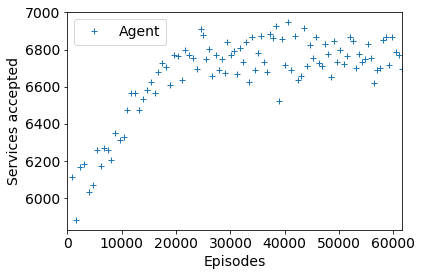

In [48]:
plt.plot(sim_time, services_accepted, '+', label='Agent')
plt.xlim([0,sim_time[-1]])
plt.xlabel("Episodes")
plt.ylabel("Services accepted")
#plt.plot(sim_time, ca_mu_result_reward, 'r', label ='CA-MU')
plt.legend()
plt.savefig('figures/learning_curve'+exp_id+'.jpeg', dpi=300,bbox_inches='tight')
plt.show()

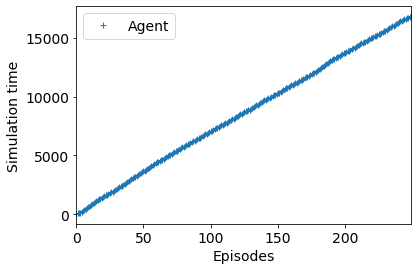

In [23]:
plt.plot(episodes, sim_time, '+', label='Agent')
plt.xlim([0,episodes[-1]])
plt.xlabel("Episodes")
plt.ylabel("Simulation time")
plt.legend()
#plt.savefig('figures/rl_agent_vs_ca_mu_reward_'+plot_name+'.jpeg', dpi=300,bbox_inches='tight')
plt.show()

Optuna Results

In [ ]:
study_name = 'studyhypv2112frGam'
with open('/Users/joshnevin/RL_FOCSLab/optuna_results/'+study_name+'.pkl', 'rb') as f:
    study = pickle.load(f)

In [ ]:
study.best_trial.params

In [ ]:
0.0004404/1e-4

In [ ]:
obs = env.reset()

In [ ]:
def speed_testing():
    total_time = 0
    obs = env.reset()
    done = False
    total_reward = []
    while not done:
        start = time.time()
        action, _states = model.predict(obs, deterministic=True)
        end = time.time()
        total_time += end-start
        obs, rewards, done, info = env.step(action)
        total_reward.append(rewards)
    return total_time, sum(total_reward)

In [ ]:
total_time, total_reward = speed_testing()

In [ ]:
total_time

In [ ]:
total_reward

In [ ]:
cProfile.run('speed_testing()')

In [ ]:
total_reward

In [ ]:
plt.plot(total_reward, '+')
plt.show()

In [ ]:
action

In [ ]:
start = time.time()
env.observation()
end = time.time()
end - start

In [ ]:
env.service.source

In [ ]:
env.service.destination

In [ ]:
env.lightpath_service_allocation

In [ ]:
cProfile.run('env.step(np.array([0,0]))')

In [ ]:
optimal_params_file = "2022-01-04exp_num.pkl"
model_params = pickle.load(open("./tmp/RWAFOCS-ppo/best_params/"+optimal_params_file, 'rb'))

In [ ]:
pwd